# Trajectory Inspection Notebook

This notebook helps you inspect and visualize recorded robot trajectories, including:
- Joint positions and gripper state
- Velocity commands (linear and angular)
- **End-effector pose trajectory** (position and orientation)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D

In [4]:
trajectory_file = "data/trajectory_20251214_185141.npz"  # <-- Updated to new file

data = np.load(trajectory_file, allow_pickle=True)

# Extract data
timestamps = data['timestamps']
states = data['states']
actions = data['actions']
metadata = data['metadata'].item() if 'metadata' in data else {}

# Load EE pose trajectory if available
ee_poses_debug = data['ee_poses_debug'] if 'ee_poses_debug' in data else None

# Load ArUco Data
aruco_keys = [
    'aruco_ee_in_world', 
    'aruco_object_in_world', 
    'aruco_ee_in_object', 
    'aruco_object_in_ee',
    'aruco_visibility'
]
aruco_data = {}
for k in aruco_keys:
    if k in data:
        aruco_data[k] = data[k]

print("\nTrajectory loaded successfully!")
print(f"\nFile: {trajectory_file}")
print(f"Number of samples: {len(timestamps)}")
print(f"Duration: {timestamps[-1]:.2f} seconds")
print(f"\nState shape: {states.shape}")
print(f"Action shape: {actions.shape}")

if ee_poses_debug is not None:
    print(f"EE pose (Mujoco) shape: {ee_poses_debug.shape}")

print("\nArUco Data Found:")
if not aruco_data:
    print("  None")
else:
    for k, v in aruco_data.items():
        print(f"  {k}: {v.shape}")

print(f"\nMetadata:")
for key, value in metadata.items():
    if key != 'ee_pose_debug_note':  # Skip long note
        print(f"  {key}: {value}")

✓ EE pose trajectory found in file

Trajectory loaded successfully!

File: data/trajectory_20251214_155402.npz
Number of samples: 491
Duration: 24.53 seconds

State shape: (491, 6)
Action shape: (491, 7)
EE pose shape: (491, 7)

Metadata:
  num_samples: 491
  control_frequency: 20.0
  duration_seconds: 24.5276082019991
  state_dim: 6
  action_dim: 7
  ee_pose_debug_dim: 7
  state_labels: ['joint_0', 'joint_1', 'joint_2', 'joint_3', 'joint_4', 'gripper']
  action_labels: ['vx', 'vy', 'vz', 'wx', 'wy', 'wz', 'gripper_target']
  ee_pose_debug_labels: ['ee_x', 'ee_y', 'ee_z', 'ee_qw', 'ee_qx', 'ee_qy', 'ee_qz']
  timestamp: 2025-12-14T15:54:35.680273


In [5]:
# Inspect state data (joint positions)
print("State data (joint positions):")
print(f"  Shape: {states.shape}")
state_labels = metadata.get('state_labels', ['joint_0', 'joint_1', 'joint_2', 'joint_3', 'joint_4', 'gripper'])
print(f"  Columns: {state_labels}")
print(f"\nFirst 5 samples:")
print(states[:5])
print(f"\nStatistics:")
print(f"  Min: {states.min(axis=0)}")
print(f"  Max: {states.max(axis=0)}")
print(f"  Mean: {states.mean(axis=0)}")

if ee_poses_debug is not None:
    print(f"\nEE Pose data:")
    print(f"  Shape: {ee_poses_debug.shape}")
    ee_labels = metadata.get('ee_pose_debug_labels', ['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz'])
    print(f"  Columns: {ee_labels}")
    print(f"\nFirst 5 samples:")
    print(ee_poses_debug[:5])
    print(f"\nStatistics:")
    print(f"  Position Min: {ee_poses_debug[:, :3].min(axis=0)}")
    print(f"  Position Max: {ee_poses_debug[:, :3].max(axis=0)}")
    print(f"  Position Mean: {ee_poses_debug[:, :3].mean(axis=0)}")

State data (joint positions):
  Shape: (491, 6)
  Columns: ['joint_0', 'joint_1', 'joint_2', 'joint_3', 'joint_4', 'gripper']

First 5 samples:
[[ 0.47411581  1.02418222 -0.80246787 -0.96664389  0.03682453 -0.02518817]
 [ 0.47411581  1.02418222 -0.80246787 -0.96664389  0.03682453 -0.02518817]
 [ 0.47411581  1.02418222 -0.80246787 -0.96664389  0.03682453 -0.02518817]
 [ 0.47411581  1.02418222 -0.80246787 -0.96664389  0.03682453 -0.02518817]
 [ 0.47411581  1.02418222 -0.80246787 -0.96664389  0.03682453 -0.02518817]]

Statistics:
  Min: [-0.37110807 -0.03802913 -0.80246787 -1.63033477 -0.6858947  -0.02518817]
  Max: [ 0.63601713  1.02418222  0.01730728 -0.81319896  0.09729091 -0.01068817]
  Mean: [ 0.24855962  0.26652741 -0.42855291 -1.17643992 -0.19075728 -0.01626149]

EE Pose data:
  Shape: (491, 7)
  Columns: ['ee_x', 'ee_y', 'ee_z', 'ee_qw', 'ee_qx', 'ee_qy', 'ee_qz']

First 5 samples:
[[ 0.19284504 -0.07831408  0.18904767  0.77273826 -0.34625726 -0.20284453
   0.49176783]
 [ 0.192845

## End-Effector Trajectory Visualization

Visualize the 3D path of the end-effector and its orientation over time.

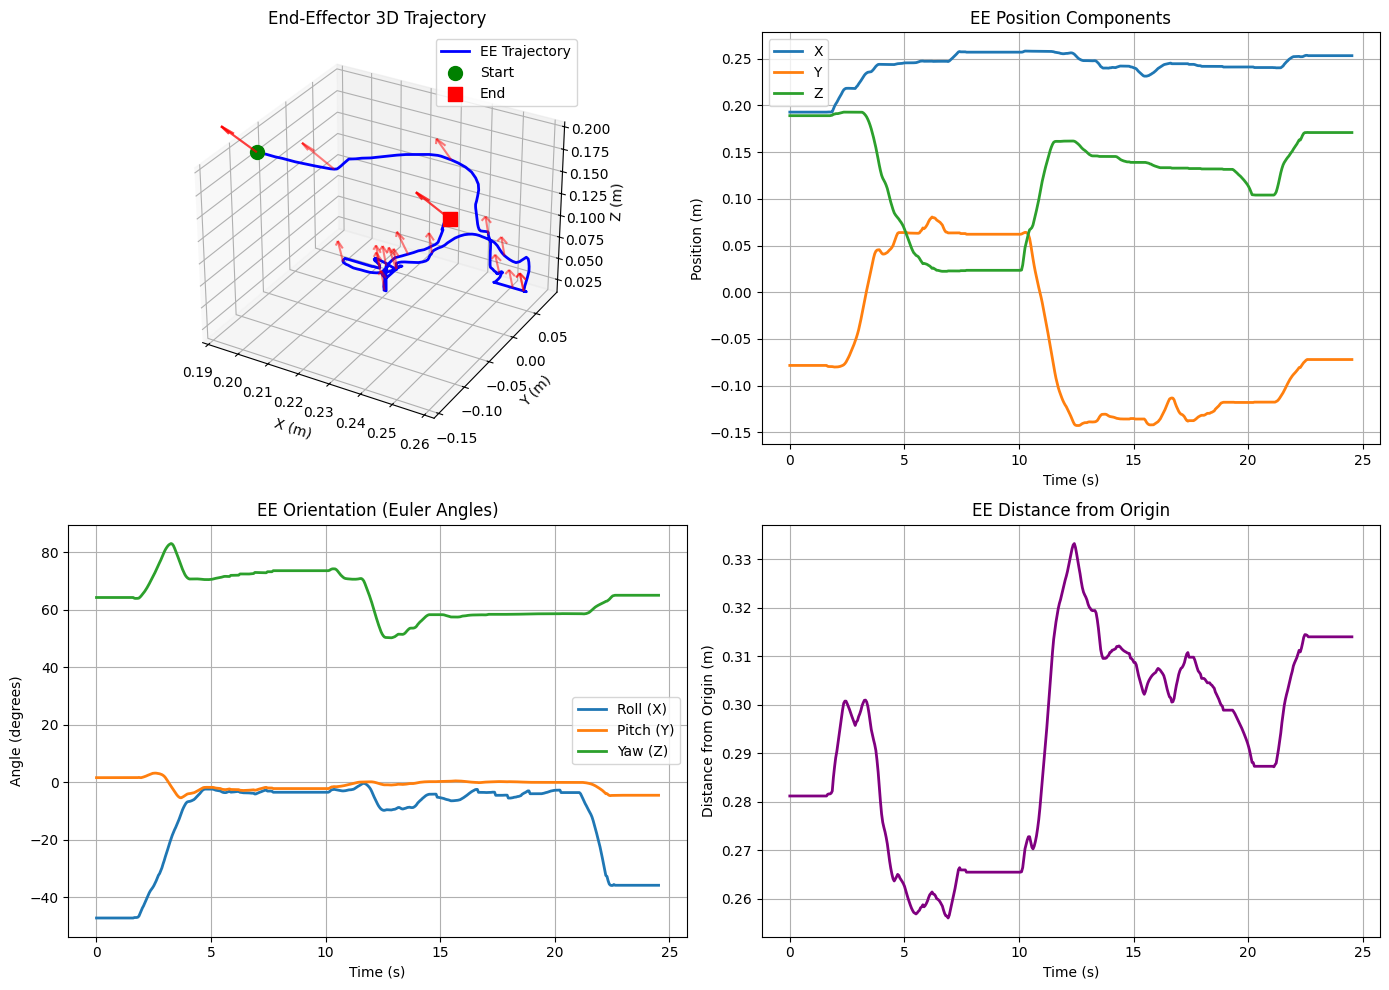


EE Trajectory Statistics:
  Total distance traveled: 0.884 m
  Position range:
    X: [0.193, 0.258] m
    Y: [-0.143, 0.081] m
    Z: [0.022, 0.193] m


In [6]:
# Visualize EE trajectory in 3D
if ee_poses_debug is not None:
    # Extract position and orientation
    ee_positions = ee_poses_debug[:, :3]  # [x, y, z]
    ee_quaternions_wxyz = ee_poses_debug[:, 3:7]  # [w, x, y, z]
    
    # Convert quaternions to rotation matrices for visualization
    # scipy uses [x, y, z, w] format
    ee_quaternions_xyzw = np.column_stack([
        ee_quaternions_wxyz[:, 1:4],  # x, y, z
        ee_quaternions_wxyz[:, 0:1]   # w
    ])
    rotations = R.from_quat(ee_quaternions_xyzw)
    
    # Create 3D plot
    fig = plt.figure(figsize=(14, 10))
    
    # 3D trajectory plot
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    ax1.plot(ee_positions[:, 0], ee_positions[:, 1], ee_positions[:, 2], 'b-', linewidth=2, label='EE Trajectory')
    ax1.scatter(ee_positions[0, 0], ee_positions[0, 1], ee_positions[0, 2], 
                color='green', s=100, marker='o', label='Start', zorder=5)
    ax1.scatter(ee_positions[-1, 0], ee_positions[-1, 1], ee_positions[-1, 2], 
                color='red', s=100, marker='s', label='End', zorder=5)
    
    # Draw orientation arrows at regular intervals
    step = max(1, len(ee_positions) // 20)  # Show ~20 arrows
    for i in range(0, len(ee_positions), step):
        rot_mat = rotations[i].as_matrix()
        arrow_length = 0.02
        ax1.quiver(ee_positions[i, 0], ee_positions[i, 1], ee_positions[i, 2],
                  rot_mat[0, 2] * arrow_length, rot_mat[1, 2] * arrow_length, rot_mat[2, 2] * arrow_length,
                  color='red', alpha=0.5, arrow_length_ratio=0.3)
    
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title('End-Effector 3D Trajectory')
    ax1.legend()
    ax1.grid(True)
    
    # Position components over time
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(timestamps, ee_positions[:, 0], label='X', linewidth=2)
    ax2.plot(timestamps, ee_positions[:, 1], label='Y', linewidth=2)
    ax2.plot(timestamps, ee_positions[:, 2], label='Z', linewidth=2)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Position (m)')
    ax2.set_title('EE Position Components')
    ax2.legend()
    ax2.grid(True)
    
    # Convert quaternions to Euler angles for visualization
    euler_angles = rotations.as_euler('xyz', degrees=True)
    
    # Orientation (Euler angles) over time
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(timestamps, euler_angles[:, 0], label='Roll (X)', linewidth=2)
    ax3.plot(timestamps, euler_angles[:, 1], label='Pitch (Y)', linewidth=2)
    ax3.plot(timestamps, euler_angles[:, 2], label='Yaw (Z)', linewidth=2)
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Angle (degrees)')
    ax3.set_title('EE Orientation (Euler Angles)')
    ax3.legend()
    ax3.grid(True)
    
    # Position magnitude (distance from origin)
    position_magnitude = np.linalg.norm(ee_positions, axis=1)
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.plot(timestamps, position_magnitude, 'purple', linewidth=2)
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Distance from Origin (m)')
    ax4.set_title('EE Distance from Origin')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print trajectory statistics
    print(f"\nEE Trajectory Statistics:")
    print(f"  Total distance traveled: {np.sum(np.linalg.norm(np.diff(ee_positions, axis=0), axis=1)):.3f} m")
    print(f"  Position range:")
    print(f"    X: [{ee_positions[:, 0].min():.3f}, {ee_positions[:, 0].max():.3f}] m")
    print(f"    Y: [{ee_positions[:, 1].min():.3f}, {ee_positions[:, 1].max():.3f}] m")
    print(f"    Z: [{ee_positions[:, 2].min():.3f}, {ee_positions[:, 2].max():.3f}] m")
else:
    print("⚠️  No EE pose trajectory data available for visualization")

In [7]:
# Inspect action data (velocity commands)
print("Action data (velocity commands):")
print(f"  Shape: {actions.shape}")
print(f"  Columns: {metadata.get('action_labels', ['vx', 'vy', 'vz', 'wx', 'wy', 'wz'])}")
print(f"\nFirst 5 samples:")
print(actions[:5])
print(f"\nStatistics:")
print(f"  Min: {actions.min(axis=0)}")
print(f"  Max: {actions.max(axis=0)}")
print(f"  Mean: {actions.mean(axis=0)}")

Action data (velocity commands):
  Shape: (491, 7)
  Columns: ['vx', 'vy', 'vz', 'wx', 'wy', 'wz', 'gripper_target']

First 5 samples:
[[ 0.          0.          0.          0.          0.          0.
  -0.02518817]
 [ 0.          0.          0.          0.          0.          0.
  -0.02518817]
 [ 0.          0.          0.          0.          0.          0.
  -0.02518817]
 [ 0.          0.          0.          0.          0.          0.
  -0.02518817]
 [ 0.          0.          0.          0.          0.          0.
  -0.02518817]]

Statistics:
  Min: [-0.03642857 -0.16       -0.13142857 -0.28       -0.73714286 -0.41142857
 -0.02518817]
  Max: [ 0.06285714  0.13142857  0.19        0.41428571  0.49714286  0.27142857
 -0.01068817]
  Mean: [ 0.00265784  0.00026186 -0.00068665  0.01794006 -0.00328775 -0.00470177
 -0.01626149]


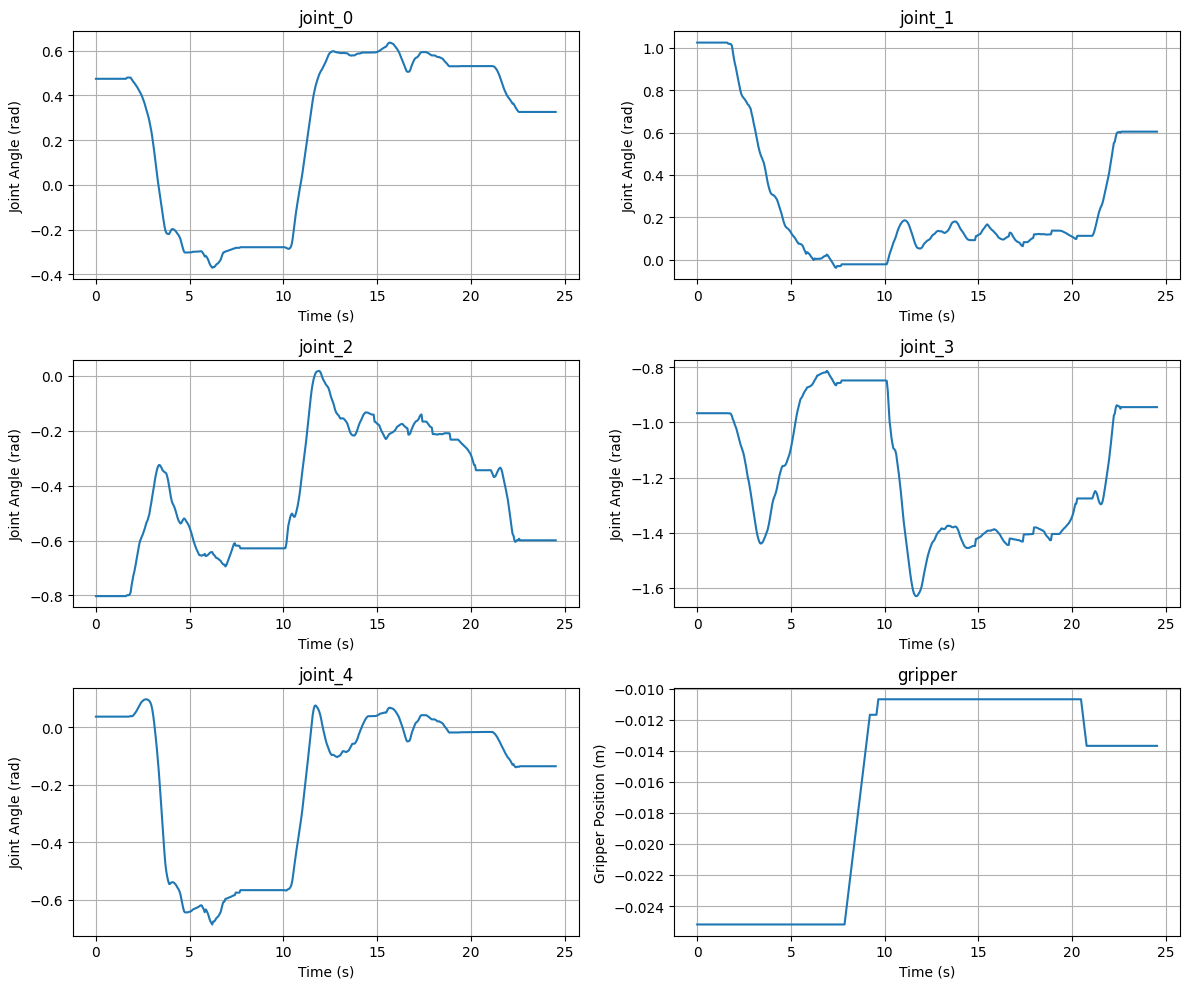

In [8]:
# Plot joint positions over time
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

state_labels = metadata.get('state_labels', ['joint_0', 'joint_1', 'joint_2', 'joint_3', 'joint_4', 'gripper'])

for i in range(6):
    axes[i].plot(timestamps, states[:, i])
    axes[i].set_title(f"{state_labels[i]}")
    axes[i].set_xlabel("Time (s)")
    if i < 5:
        axes[i].set_ylabel("Joint Angle (rad)")
    else:
        axes[i].set_ylabel("Gripper Position (m)")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

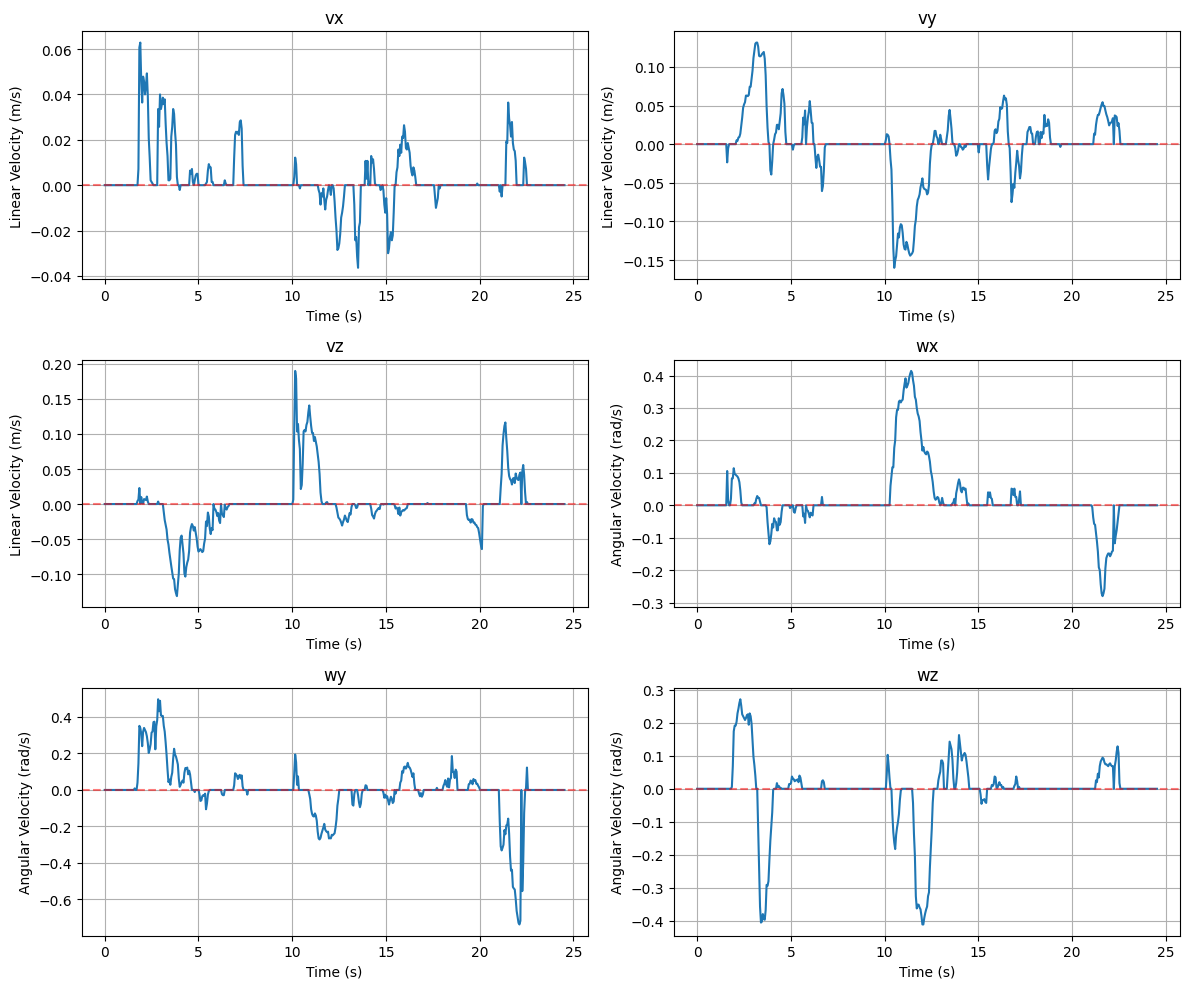

In [9]:
# Plot velocity commands over time
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

action_labels = metadata.get('action_labels', ['vx', 'vy', 'vz', 'wx', 'wy', 'wz'])

for i in range(6):
    axes[i].plot(timestamps, actions[:, i])
    axes[i].set_title(f"{action_labels[i]}")
    axes[i].set_xlabel("Time (s)")
    if i < 3:
        axes[i].set_ylabel("Linear Velocity (m/s)")
    else:
        axes[i].set_ylabel("Angular Velocity (rad/s)")
    axes[i].grid(True)
    axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

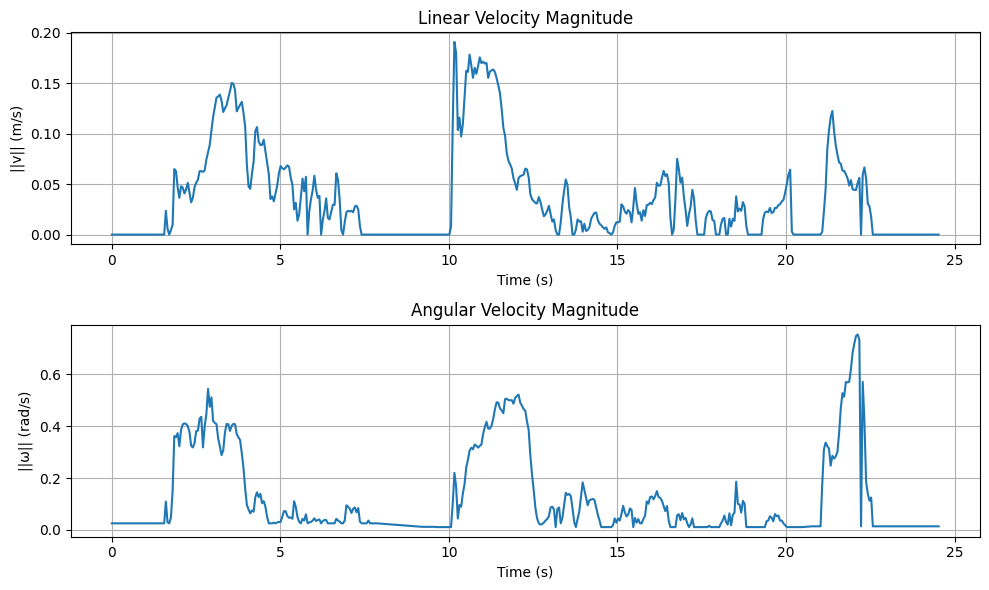

In [10]:
# Plot velocity magnitude over time
linear_velocity_magnitude = np.linalg.norm(actions[:, :3], axis=1)
angular_velocity_magnitude = np.linalg.norm(actions[:, 3:], axis=1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

ax1.plot(timestamps, linear_velocity_magnitude)
ax1.set_title("Linear Velocity Magnitude")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("||v|| (m/s)")
ax1.grid(True)

ax2.plot(timestamps, angular_velocity_magnitude)
ax2.set_title("Angular Velocity Magnitude")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("||ω|| (rad/s)")
ax2.grid(True)

plt.tight_layout()
plt.show()

Sampling statistics:
  Mean dt: 50.06 ms
  Actual frequency: 19.98 Hz
  Expected frequency: 20.0 Hz
  Min dt: 49.76 ms
  Max dt: 50.41 ms
  Std dt: 0.08 ms


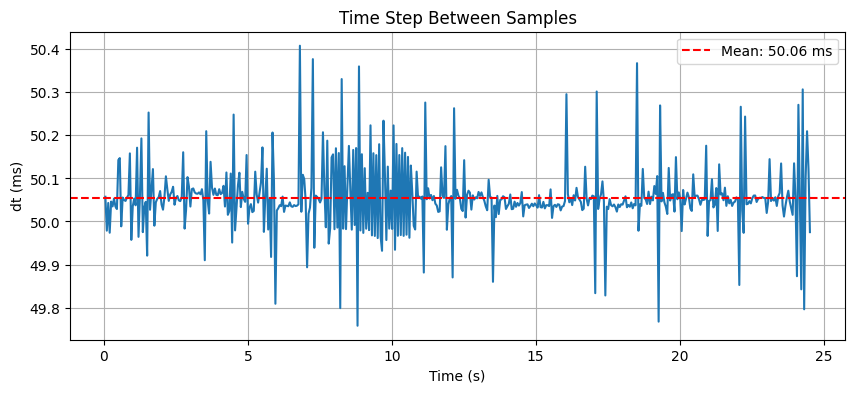

In [11]:
# Check sampling frequency
dt = np.diff(timestamps)
mean_dt = np.mean(dt)
actual_frequency = 1.0 / mean_dt

print(f"Sampling statistics:")
print(f"  Mean dt: {mean_dt*1000:.2f} ms")
print(f"  Actual frequency: {actual_frequency:.2f} Hz")
print(f"  Expected frequency: {metadata.get('control_frequency', 50.0):.1f} Hz")
print(f"  Min dt: {dt.min()*1000:.2f} ms")
print(f"  Max dt: {dt.max()*1000:.2f} ms")
print(f"  Std dt: {dt.std()*1000:.2f} ms")

plt.figure(figsize=(10, 4))
plt.plot(timestamps[1:], dt * 1000)
plt.xlabel("Time (s)")
plt.ylabel("dt (ms)")
plt.title("Time Step Between Samples")
plt.grid(True)
plt.axhline(y=mean_dt*1000, color='r', linestyle='--', label=f'Mean: {mean_dt*1000:.2f} ms')
plt.legend()
plt.show()

In [12]:
# Summary statistics
print("="*60)
print("TRAJECTORY SUMMARY")
print("="*60)
print(f"File: {trajectory_file}")
print(f"Duration: {timestamps[-1]:.2f} seconds")
print(f"Number of samples: {len(timestamps)}")
print(f"Control frequency: {actual_frequency:.2f} Hz")
print(f"\nState ranges:")
for i, label in enumerate(state_labels):
    print(f"  {label:15s}: [{states[:, i].min():8.4f}, {states[:, i].max():8.4f}]")
print(f"\nAction ranges:")
for i, label in enumerate(action_labels):
    print(f"  {label:15s}: [{actions[:, i].min():8.4f}, {actions[:, i].max():8.4f}]")

TRAJECTORY SUMMARY
File: data/trajectory_20251214_155402.npz
Duration: 24.53 seconds
Number of samples: 491
Control frequency: 19.98 Hz

State ranges:
  joint_0        : [ -0.3711,   0.6360]
  joint_1        : [ -0.0380,   1.0242]
  joint_2        : [ -0.8025,   0.0173]
  joint_3        : [ -1.6303,  -0.8132]
  joint_4        : [ -0.6859,   0.0973]
  gripper        : [ -0.0252,  -0.0107]

Action ranges:
  vx             : [ -0.0364,   0.0629]
  vy             : [ -0.1600,   0.1314]
  vz             : [ -0.1314,   0.1900]
  wx             : [ -0.2800,   0.4143]
  wy             : [ -0.7371,   0.4971]
  wz             : [ -0.4114,   0.2714]
  gripper_target : [ -0.0252,  -0.0107]


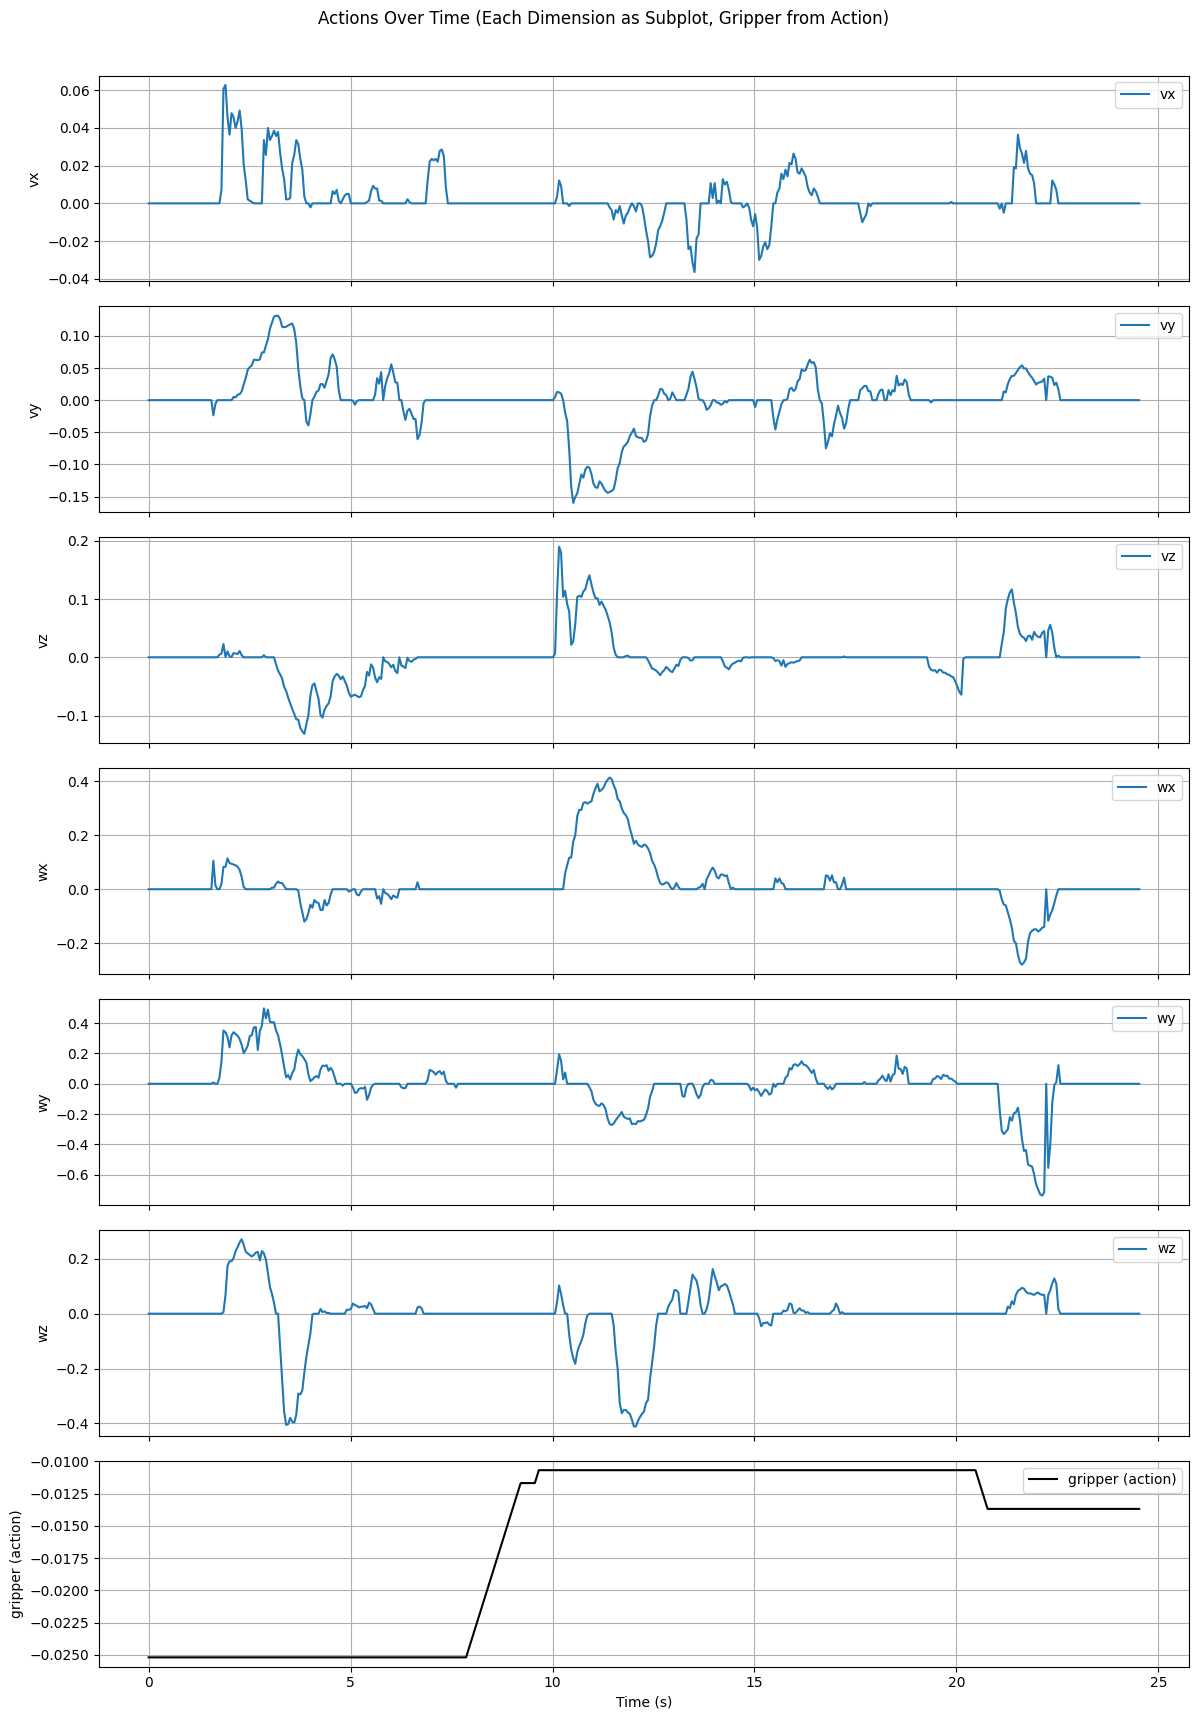

In [13]:
# Plot each action dimension as a subplot, treating "gripper" as an action (not state)
num_actions = actions.shape[1]
gripper_in_action = 'gripper' in action_labels

# Identify gripper action dimension
if gripper_in_action:
    gripper_action_idx = action_labels.index('gripper')
else:
    # Assume last column is gripper if not explicitly labeled (legacy support)
    gripper_action_idx = num_actions - 1

# Exclude gripper from the first (non-gripper) action subplots for clarity
non_gripper_action_indices = [i for i in range(num_actions) if i != gripper_action_idx]
n_non_gripper = len(non_gripper_action_indices)

# Always add separate gripper action subplot
nplots = n_non_gripper + 1
fig, axs = plt.subplots(nplots, 1, figsize=(12, 2.5 * nplots), sharex=True)

if nplots == 1:
    axs = [axs]  # Make iterable

# Plot non-gripper action dimensions
for ax_idx, i in enumerate(non_gripper_action_indices):
    axs[ax_idx].plot(timestamps, actions[:, i], label=action_labels[i])
    axs[ax_idx].set_ylabel(action_labels[i])
    axs[ax_idx].legend()
    axs[ax_idx].grid(True)

# Plot gripper action as final subplot
axs[-1].plot(timestamps, actions[:, gripper_action_idx], label='gripper (action)', color='k')
axs[-1].set_ylabel('gripper (action)')
axs[-1].legend()
axs[-1].grid(True)

axs[-1].set_xlabel("Time (s)")
fig.suptitle("Actions Over Time (Each Dimension as Subplot, Gripper from Action)")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


(472, 7)

## ArUco Tracking Visualization

The following plots show the data collected from the ArUco marker tracking system.
- **Visibility**: Which markers were detected.
- **World Frame Poses**: Position of Gripper (ID 3) and Object (ID 2) relative to World (ID 0).
- **Relative Poses**: Position of Object relative to Gripper, and vice versa.

In [ ]:
if 'aruco_visibility' in aruco_data:
    vis = aruco_data['aruco_visibility']
    
    plt.figure(figsize=(15, 3))
    plt.imshow(vis.T, aspect='auto', interpolation='nearest', cmap='gray_r', extent=[timestamps[0], timestamps[-1], -0.5, 2.5])
    plt.yticks([0, 1, 2], ['World (0)', 'Object (2)', 'Gripper (3)'])
    plt.xlabel('Time (s)')
    plt.title('Marker Visibility (Black = Visible)')
    plt.grid(False)
    plt.show()
    
    # Print stats
    print(f"Visibility Stats (% of frames):")
    print(f"  World:   {np.mean(vis[:, 0])*100:.1f}%")
    print(f"  Object:  {np.mean(vis[:, 1])*100:.1f}%")
    print(f"  Gripper: {np.mean(vis[:, 2])*100:.1f}%")
else:
    print("No visibility data found.")

In [ ]:
if 'aruco_ee_in_world' in aruco_data and 'aruco_object_in_world' in aruco_data:
    ee_in_world = aruco_data['aruco_ee_in_world']
    obj_in_world = aruco_data['aruco_object_in_world']
    vis = aruco_data.get('aruco_visibility', np.ones((len(timestamps), 3)))
    
    # Filter out zeros (non-visible)
    # Only plot if World + Subject is visible
    valid_ee = (vis[:, 0] > 0.5) & (vis[:, 2] > 0.5)
    valid_obj = (vis[:, 0] > 0.5) & (vis[:, 1] > 0.5)
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    labels = ['X', 'Y', 'Z']
    
    for i in range(3):
        # Plot EE
        axes[i].plot(timestamps[valid_ee], ee_in_world[valid_ee, i], '.', label='Gripper (ID 3)', alpha=0.5, markersize=3)
        # Plot Object
        axes[i].plot(timestamps[valid_obj], obj_in_world[valid_obj, i], '.', label='Object (ID 2)', alpha=0.5, markersize=3)
        
        axes[i].set_ylabel(f'{labels[i]} Position (m)')
        axes[i].grid(True, alpha=0.3)
        if i == 0: axes[i].legend()
        
    axes[-1].set_xlabel('Time (s)')
    plt.suptitle('Positions in World Frame (from ArUco)')
    plt.show()
else:
    print("World frame data missing.")

In [ ]:
if 'aruco_object_in_ee' in aruco_data:
    obj_in_ee = aruco_data['aruco_object_in_ee']
    vis = aruco_data.get('aruco_visibility', np.ones((len(timestamps), 3)))
    
    # Valid only if both Gripper and Object are visible
    valid = (vis[:, 1] > 0.5) & (vis[:, 2] > 0.5)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # 1. Distance
    dist = np.linalg.norm(obj_in_ee[:, :3], axis=1)
    axes[0].plot(timestamps[valid], dist[valid], '.', color='purple', markersize=3)
    axes[0].set_ylabel('Distance (m)')
    axes[0].set_title('Object Distance from Gripper')
    axes[0].grid(True)
    
    # 2. XYZ Components
    labels = ['x', 'y', 'z']
    colors = ['r', 'g', 'b']
    for i in range(3):
        axes[1].plot(timestamps[valid], obj_in_ee[valid, i], '.', color=colors[i], label=f'{labels[i]}', alpha=0.6, markersize=3)
        
    axes[1].set_ylabel('Relative Position (m)')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_xlabel('Time (s)')
    
    plt.show()
else:
    print("Relative pose data missing.")

In [ ]:
# Using Plotly for interactive 3D visualization (no matplotlib needed)
import plotly.graph_objects as go
import plotly.io as pio
from scipy.spatial.transform import Rotation as R

# Try to set a robust renderer
# pio.renderers.default = "notebook" # Unwrap if needed

def draw_rgb_axes(fig, pos, quat_wxyz, axis_length=0.02, name_prefix=""):
    """Draw RGB coordinate axes (X=red, Y=green, Z=blue) at a pose.
    
    Args:
        fig: Plotly figure
        pos: 3D position [x, y, z]
        quat_wxyz: Quaternion [w, x, y, z]
        axis_length: Length of each axis in meters
        name_prefix: Prefix for trace names
    """
    # Convert quaternion (wxyz) to rotation matrix
    quat_xyzw = np.array([quat_wxyz[1], quat_wxyz[2], quat_wxyz[3], quat_wxyz[0]])  # Convert to xyzw
    rot = R.from_quat(quat_xyzw)
    R_matrix = rot.as_matrix()
    
    # Define axis directions in local frame (unit vectors)
    axes_local = np.array([
        [axis_length, 0, 0],  # X axis (red)
        [0, axis_length, 0],  # Y axis (green)
        [0, 0, axis_length]   # Z axis (blue)
    ])
    
    # Transform to world frame
    axes_world = (R_matrix @ axes_local.T).T + pos
    
    # Colors: RGB convention
    colors = ['red', 'green', 'blue']
    labels = ['X', 'Y', 'Z']
    
    for i in range(3):
        fig.add_trace(go.Scatter3d(
            x=[pos[0], axes_world[i, 0]],
            y=[pos[1], axes_world[i, 1]],
            z=[pos[2], axes_world[i, 2]],
            mode='lines',
            name=f'{name_prefix} {labels[i]}',
            line=dict(color=colors[i], width=3),
            showlegend=(i == 0),  # Only show legend for first axis of each pose
            legendgroup=name_prefix
        ))

if 'aruco_ee_in_world' in aruco_data and 'aruco_object_in_world' in aruco_data:
    ee_in_world = aruco_data['aruco_ee_in_world']
    obj_in_world = aruco_data['aruco_object_in_world']
    vis = aruco_data.get('aruco_visibility', np.ones((len(timestamps), 3)))
    
    valid_ee = (vis[:, 0] > 0.5) & (vis[:, 2] > 0.5)
    valid_obj = (vis[:, 0] > 0.5) & (vis[:, 1] > 0.5)

    fig = go.Figure()

    # Plot EE Path
    fig.add_trace(go.Scatter3d(
        x=ee_in_world[valid_ee, 0], 
        y=ee_in_world[valid_ee, 1], 
        z=ee_in_world[valid_ee, 2], 
        mode='lines',
        name='Gripper Path', 
        line=dict(color='blue', width=4),
        opacity=0.7
    ))
            
    # Plot Object Positions
    fig.add_trace(go.Scatter3d(
        x=obj_in_world[valid_obj, 0], 
        y=obj_in_world[valid_obj, 1], 
        z=obj_in_world[valid_obj, 2], 
        mode='markers',
        name='Object', 
        marker=dict(size=5, color='red', opacity=0.3)
    ))
               
    # Plot Origin (World Tag)
    fig.add_trace(go.Scatter3d(
        x=[0], y=[0], z=[0], 
        mode='markers',
        name='World Origin', 
        marker=dict(size=10, color='black', symbol='x')
    ))

    # Draw RGB axes for EE (sample every Nth frame to avoid clutter)
    ee_valid_indices = np.where(valid_ee)[0]
    if len(ee_valid_indices) > 0:
        # Sample frames: every 10th frame or at least 20 frames total
        step = max(1, len(ee_valid_indices) // 20)
        sampled_indices = ee_valid_indices[::step]
        
        for idx in sampled_indices:
            pos = ee_in_world[idx, :3]
            quat = ee_in_world[idx, 3:7]  # wxyz format
            draw_rgb_axes(fig, pos, quat, axis_length=0.02, name_prefix="EE")
    
    # Draw RGB axes for Object (sample every Nth frame)
    obj_valid_indices = np.where(valid_obj)[0]
    if len(obj_valid_indices) > 0:
        step = max(1, len(obj_valid_indices) // 20)
        sampled_indices = obj_valid_indices[::step]
        
        for idx in sampled_indices:
            pos = obj_in_world[idx, :3]
            quat = obj_in_world[idx, 3:7]  # wxyz format
            draw_rgb_axes(fig, pos, quat, axis_length=0.02, name_prefix="Object")

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data',
        ),
        width=1000,
        height=800,
        legend=dict(itemsizing='constant'),
        title='3D Trajectory with RGB Poses (X=Red, Y=Green, Z=Blue) [Interactive]',
        margin=dict(l=20, r=20, b=20, t=50),
    )
    
    try:
        fig.show()
    except ValueError as e:
        print(f"Error showing interactive plot: {e}")
        print("Attempting fallback to static renderer...")
        try:
            fig.show(renderer="png")
        except:
            print("Could not render plot. Please ensure nbformat is installed and kernel is restarted.")
else:
    print("3D data missing.")